In [1]:
!pip install git+https://github.com/asteroid-team/asteroid.git@master --quiet

In [3]:
!pip install matplotlib


     |████████████████████████████████| 10.3 MB 16.4 MB/s 
     |████████████████████████████████| 3.0 MB 11.9 MB/s 
     |████████████████████████████████| 1.2 MB 16.0 MB/s 


In [4]:
%matplotlib inline

In [5]:
import torch
from asteroid_filterbanks.enc_dec import Filterbank, Encoder, Decoder
from asteroid_filterbanks import FreeFB
import matplotlib.pyplot as plt

In [24]:
import soundfile as sf
import numpy as np

In [81]:
waveform_8k, rate1 = sf.read("/home/zhz_test/journal2021/data_scp/fileid6_8k/data/noisy/fileid_6.wav")
print(waveform_8k.shape)
waveform_8k.shape = (1, 1, 80000)
print(waveform_8k.shape)

waveform_16k, rate1 = sf.read("/raid/zhz_test/DNS-align/test_set/synthetic/no_reverb/noisy/fileid_6.wav")
print(waveform_16k.shape)
waveform_16k.shape = (1, 1, 160000)
print(waveform_16k.shape)

waveform_vb_16k, rate1 = sf.read("/raid/zhz_test/VB/16k/noisy_testset_wav/p232_005.wav")
print(waveform_vb_16k.shape)
waveform_vb_16k.shape = (1, 1, 99946)
print(waveform_vb_16k.shape)

waveform = torch.from_numpy(waveform_vb_16k) 

(80000,)
(1, 1, 80000)
(160000,)
(1, 1, 160000)
(99946,)
(1, 1, 99946)


In [82]:
from asteroid_filterbanks import multiphase_gammatone
# First, instantiate a filterbank
fb = multiphase_gammatone(n_filters=512, kernel_size=16, stride=8)
# Make an encoder out of it, forward some waveform through it.
encoder = Encoder(fb).double()
# Same for decoder (the filterbank doesn't need to be the same)
#decoder_fb = Decoder.pinv_of(encoder).double()
decoder_fb = multiphase_gammatone(n_filters=512, kernel_size=16, stride=8).double()
decoder = Decoder(decoder_fb)
# waveform = torch.randn(1, 1, 32000)  # (batch, channel, wav_lenght)
# This would be the output of an adaptative/learnable front-end like in TasNet.
spec_like = encoder(waveform.double())
# Do whatever you want with it
modif_spec_like = (spec_like.pow(2) + 1).log()
# Go back in the time domain with the decoder.
out_waveform = decoder(modif_spec_like)

In [104]:
spec_like_new = spec_like.squeeze(0).detach().cpu().numpy()
with open('/home/zhz_test/journal2021/data_scp/illustration_unmatched/two-step-gamma-new.npy', 'wb') as f:
    np.save(f, spec_like_new)

torch.Size([1, 512, 12492])
(512, 12492)
-0.008937578577506322 0.008937578577506322


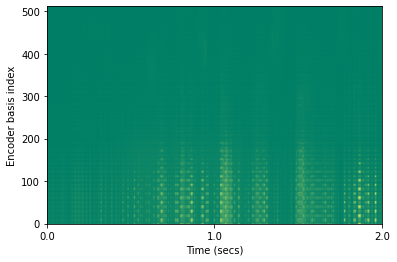

In [106]:
print(spec_like.size())
spec_like_new = spec_like.squeeze(0).detach().cpu().numpy()
print(spec_like_new.shape)
spec_like_new = spec_like_new[:, :3998] #3198 or 3998
print(np.amin(spec_like_new), np.amax(spec_like_new))
#spec_like_new = np.where(spec_like_new>0.000, spec_like_new+0.0005, spec_like_new)
spec_like_new = np.where(spec_like_new>0.0025, spec_like_new+0.0085, spec_like_new)
#spec_like_new = np.where(spec_like_new>0.0005, spec_like_new+0.002, spec_like_new)
#spec_like_new = np.where(spec_like_new>0.00415, spec_like_new+0.002, spec_like_new)
plt.subplot(111)
plt.imshow(np.abs(spec_like_new), cmap='summer', aspect='auto')
plt.gca().invert_yaxis()
plt.xlabel('Time (secs)')
plt.ylabel('Encoder basis index')
plt.xticks([0, 1999, 3998], [0.0, 1.0, 2.0])
plt.show()

In [62]:
import matplotlib as mpl
def set_style():
    #plt.style.use('classic')
    
    nice_fonts = {
            # Use LaTeX to write all text
            "font.family": "serif",
            # Use 10pt font in plots, to match 10pt font in document
            "axes.labelsize": 20,
            "font.size": 20,
            # Make the legend/label fonts a little smaller
            "legend.fontsize": 18,
            "xtick.labelsize": 18,
            "ytick.labelsize": 18,
    }
    mpl.rcParams.update(nice_fonts)

(512, 1998)


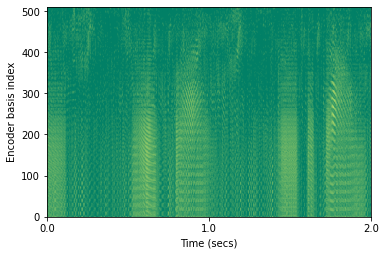

In [64]:
feat = spec_like_new
print(feat.shape) #256, 15999/
plt.imshow(np.abs(feat), cmap='summer', aspect='auto')
plt.gca().invert_yaxis()
plt.xlabel('Time (secs)')
plt.ylabel('Encoder basis index')
plt.gcf().subplots_adjust(bottom=0.15)
plt.gcf().subplots_adjust(left=0.15)

plt.xticks([0, 999, 1998], [0.0, 1.0, 2.0])
    #plt.yticks([0, 50, 100, 150, 200, 250], [0, 100, 200, 300, 400, 500])
    # plt.xticks([1598, 3197, 4796, 6395, 7994, 9593, 11192, 12791, 14390, 15988], [1,2,3,4,5,6,7,8,9,10])
    # plt.xticks(np.arange(10),('1','2','3','4','5','6','7','8','9','10'))
    #plt.colorbar()
plt.savefig("/home/zhz_test/journal2021/data_scp/illustration_matched/two-step-gamma.pdf")

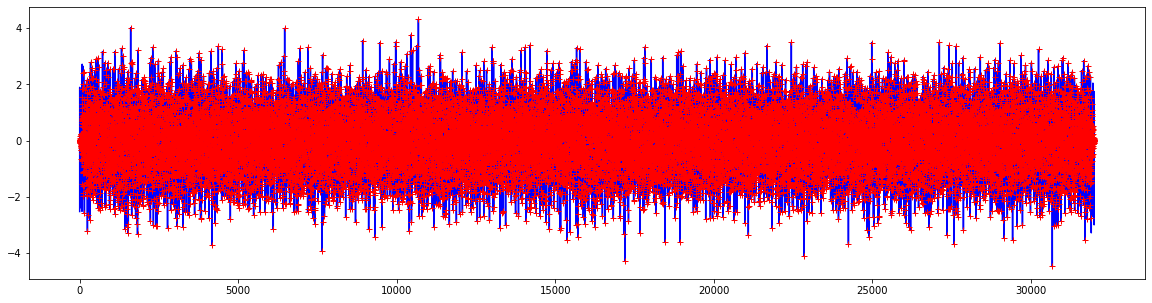

In [7]:
from asteroid_filterbanks import STFTFB
# By default, the filters are weighted by a square root hanning window.
dft_filters = STFTFB(n_filters=512, kernel_size=256, stride=128)
stft = Encoder(dft_filters)
idft_filters = STFTFB(n_filters=512, kernel_size=256, stride=128)
istft = Decoder(idft_filters)

spec = stft(waveform)
out_waveform = istft(spec)

# We can plot to see the output is the same as the input.
fig, axes = plt.subplots(figsize=(20, 5))
axes.plot(waveform.squeeze().data.numpy(), 'b')
axes.plot(out_waveform.squeeze().data.numpy(), 'r+')
plt.show()
